In [2]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter

import os
import rasterio
import shapely.geometry

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



In [3]:
images = !ls /home/ubuntu/data/TX_post/training_tiles/*_img.npy

In [4]:
len(images)

8622

In [5]:
tile_no = len(images)

('Random tile #:', 1736)
('% flooding labeled:', 0.0)


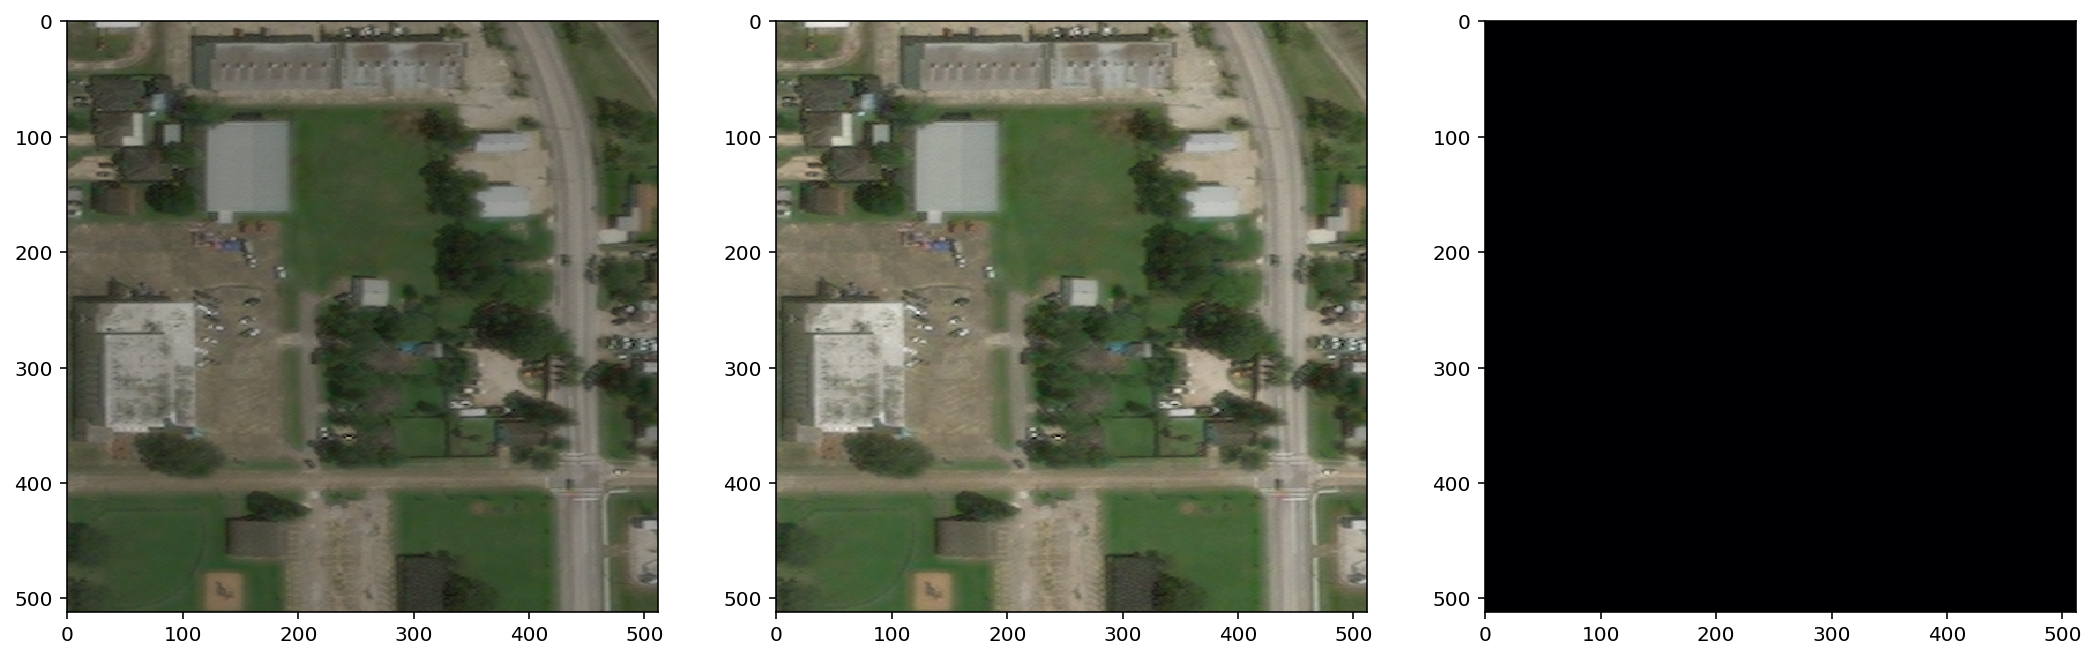

In [6]:
tile_pick = random.randint(0,tile_no-1)  #chooses a random tiletile_no = tile_no + 73
print("Random tile #:",tile_pick)
img = np.load('/home/ubuntu/data/TX_post/training_tiles/%d_img.npy'%tile_pick)
mask = np.load('/home/ubuntu/data/TX_post/training_tiles/%d_mask.npy'%tile_pick)

fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(18,12))
ax0.imshow(img)
ax0.imshow(mask,cmap='inferno',alpha = 0.2)
ax1.imshow(img)
ax2.imshow(mask,cmap='inferno');
print("% flooding labeled:",(mask.sum()/255.)/(mask.shape[0]*mask.shape[1]))

('Random tile #:', 5008)


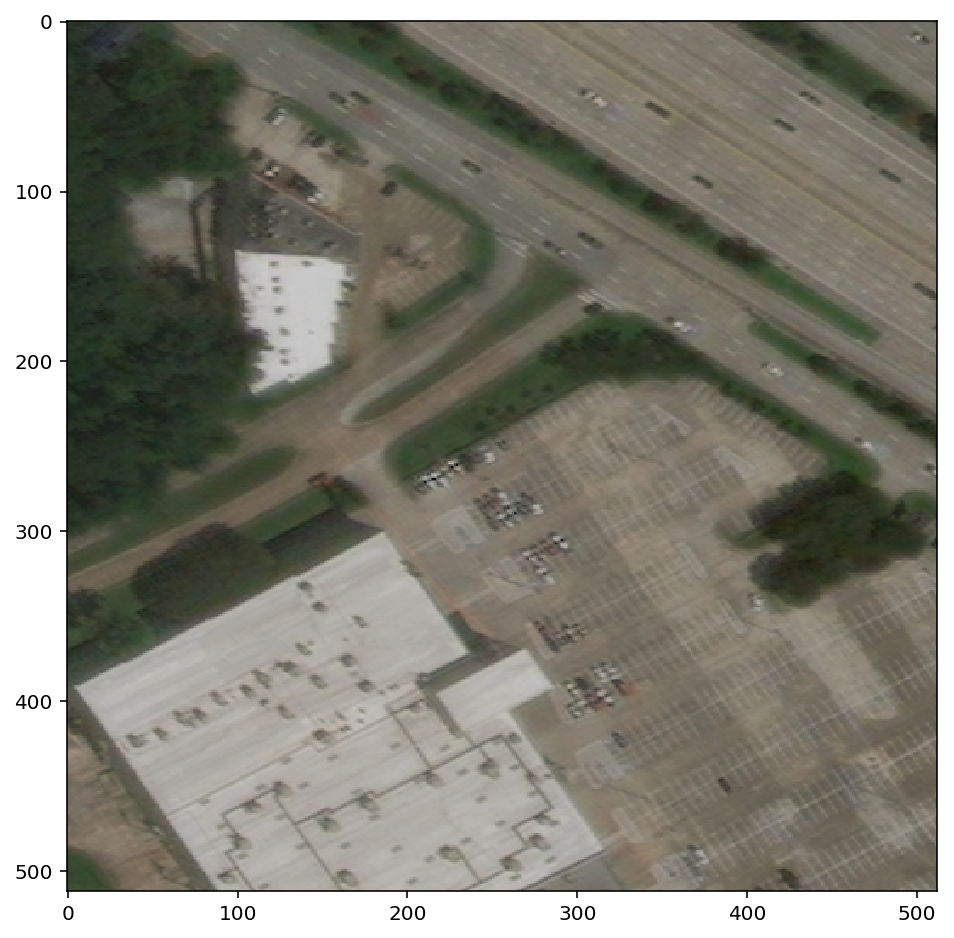

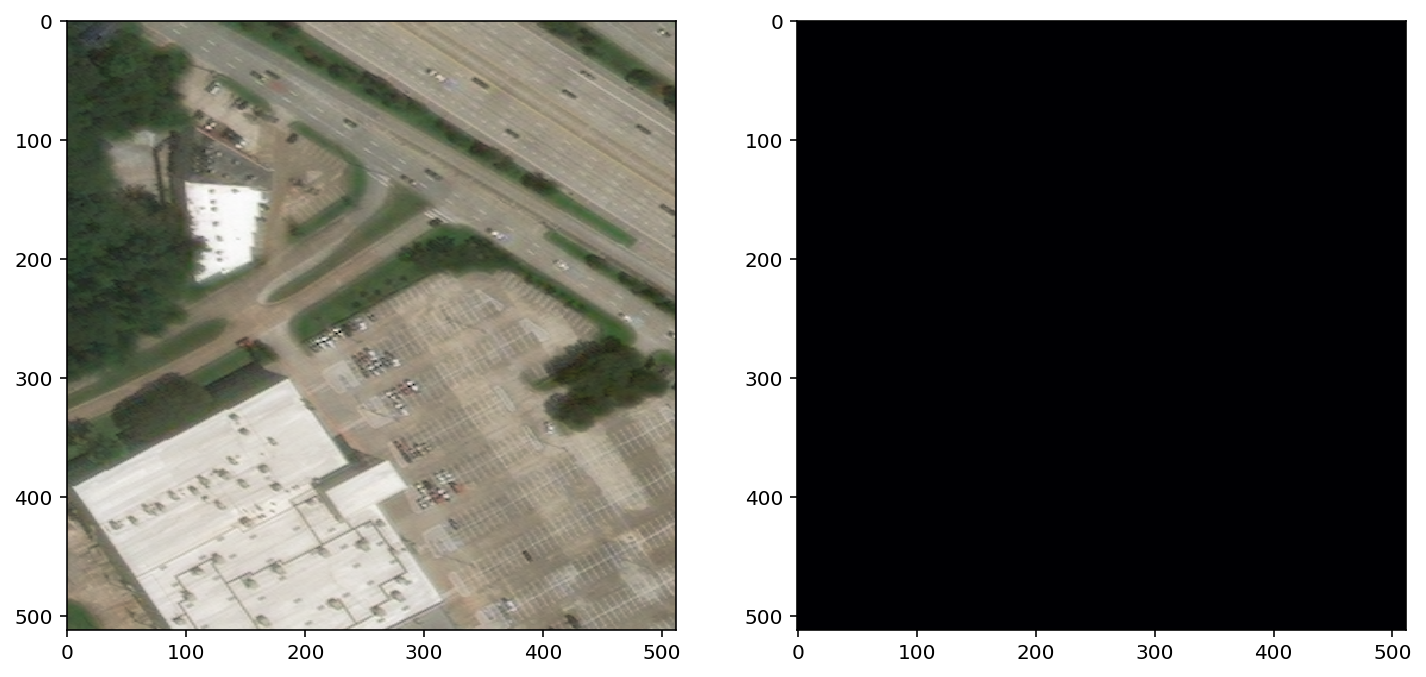

In [7]:
tile_pick = random.randint(0,tile_no-1)  #chooses a random tiletile_no = tile_no + 73
print("Random tile #:",tile_pick)
img = np.load('/home/ubuntu/data/TX_post/training_tiles/%d_img.npy'%tile_pick)
mask = np.load('/home/ubuntu/data/TX_post/training_tiles/%d_mask.npy'%tile_pick)

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow(img)
ax.imshow(mask,cmap='inferno',alpha = 0.2);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
ax1.imshow(img)
ax2.imshow(mask,cmap='inferno');

In [8]:
tile_pick

5008

# pick a random training file to look at

In [9]:
from sklearn.cluster import dbscan

In [577]:
tile_pick = np.random.randint(0,len(images)-1)
tile_pick
#tile_pick = 5008

3229

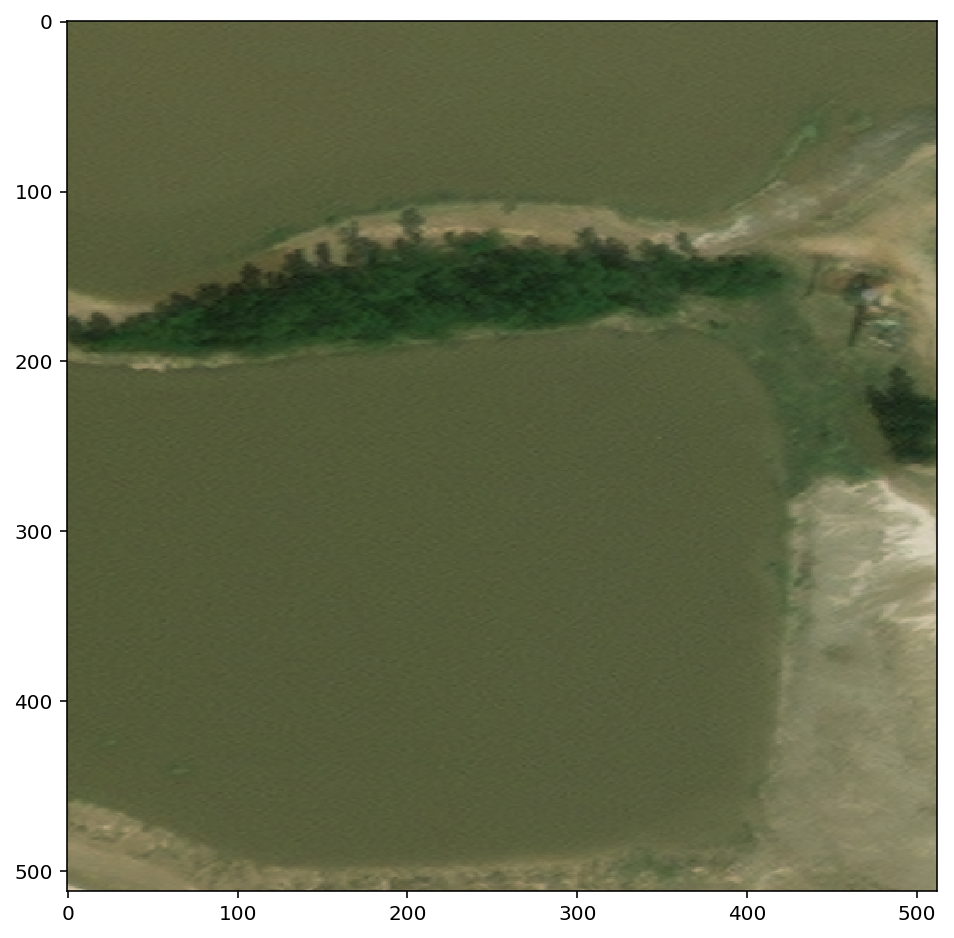

In [578]:
img = np.load('/home/ubuntu/data/TX_post/training_tiles_v3/%d_img.npy'%tile_pick)
DGmask = np.load('/home/ubuntu/data/TX_post/training_tiles_v3/%d_mask.npy'%tile_pick)
plt.figure(figsize=(8,8))
plt.imshow(img);

In [579]:
#image is to large for cluster algorithm, try making it smaller
side = 300
img = img[:side,:side]
DGmask = DGmask[:side,:side]

In [580]:
axis = np.linspace(0,255,side)/100.
x = np.zeros((side,side))+axis
#x = np.expand_dims(x,axis=2)
y = np.rot90(x,k=1)
#y = np.expand_dims(y,axis=2)
features = np.stack((img[:,:,0],img[:,:,1],img[:,:,2],x,y),axis=2)
features.shape

(300, 300, 5)

In [581]:
flat_img = np.reshape(features,(features.shape[0]**2,features.shape[2]))
flat_img.shape

(90000, 5)

In [582]:
clustered = dbscan(flat_img,eps=1.48,min_samples=50,n_jobs=-2)

In [583]:
side = int(clustered[1].shape[0]**0.5)
mask = np.reshape(clustered[1],(side,side))

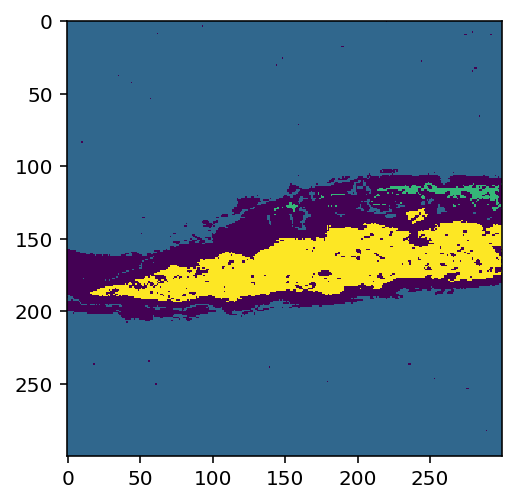

In [584]:
plt.imshow(mask);

In [585]:
c_count=Counter(mask.flatten())
c_count.most_common()

[(0, 70296), (-1, 11377), (2, 7823), (1, 504)]

In [586]:
order = [x[0] for x in c_count.most_common() if x[0]>= 0]  #gets cluster index, AND throws out the negative-1 group
order   

[0, 2, 1]

In [587]:
ready = False

while ready==False:
    if len(order)==0:
        ready=True
        mask = np.zeros((side,side))
        continue
        
    c_id = order[0]
    color_sum = (img*(np.expand_dims(mask==c_id,axis=2))).sum(axis=(0,1))
    
    if color_sum.std()*1.0/color_sum.mean() < 0.09:   #reject if too grey/white/black
        print("too grey, reject cluster",order[0])
        order = order[1:]
        continue
    
    elif 1.0*color_sum[1]/color_sum[0] > 1.1:  #if the most common color is too green, reject it and move to the next
        print(color_sum[1]*1.0/color_sum[0])
        print("too green, reject cluster ",order[0])
        order=order[1:]
        
    
    else:ready=True
    
 
"""if color_sum[1] > 1.1*color_sum[0]:  #if the most common color is too green, reject it and move to the next
    order=order[1:]
    c_id = order[0]
color_sum = (img*(np.expand_dims(mask==c_id,axis=2))).sum(axis=(0,1))
if color_sum[0]*1.0/color_sum[2] < 1.21:   # if the material is too 'grey' reject it and move to the next
    order=order[1:]
    c_id = order[0]
if order[0] == -1: 
    order=order[1:]
    c_id = order[0]"""
print("floodwater/mud at id",c_id)



('floodwater/mud at id', 0)


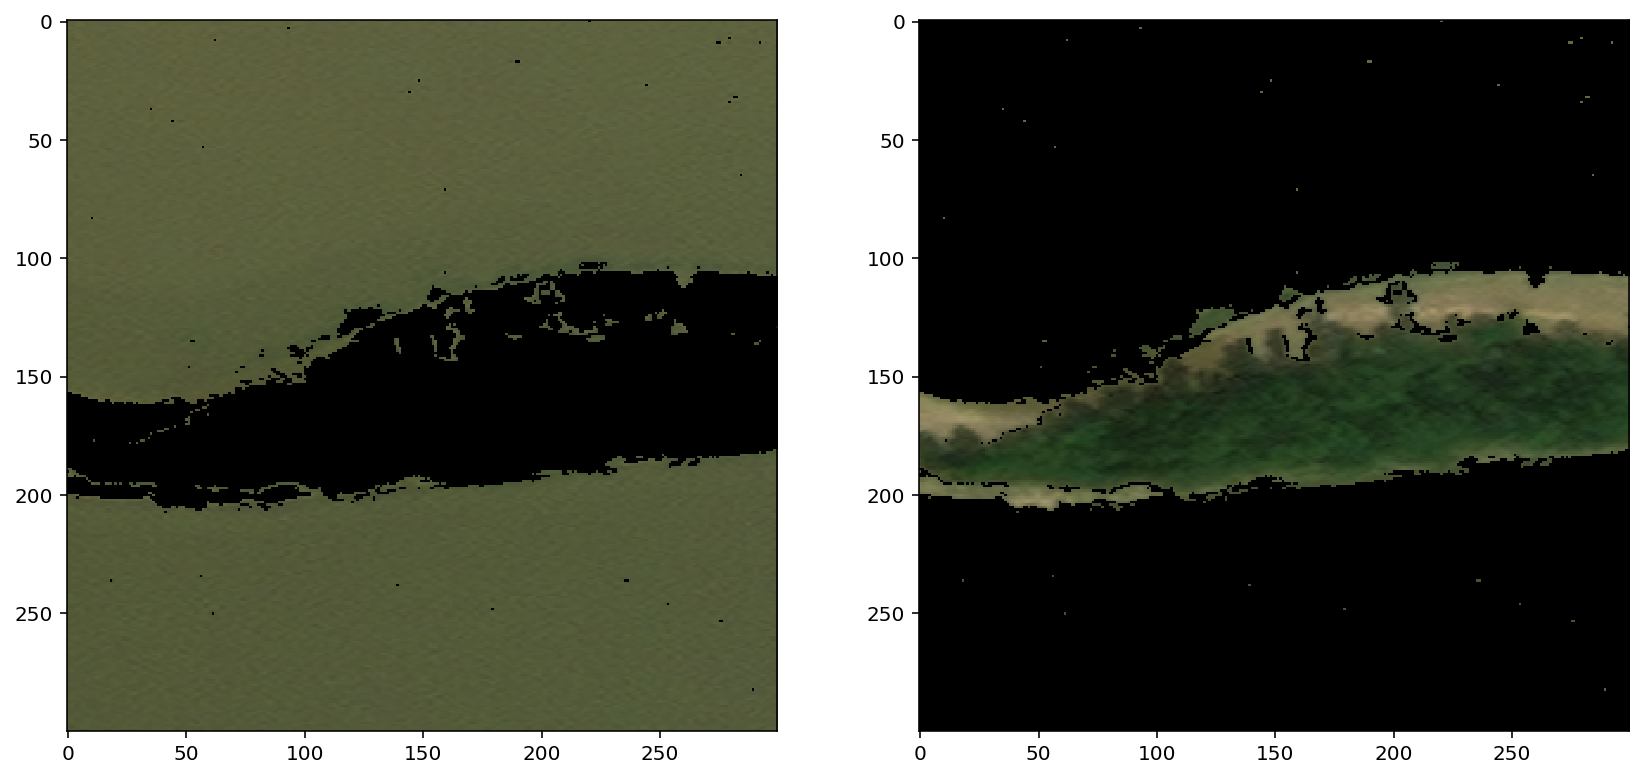

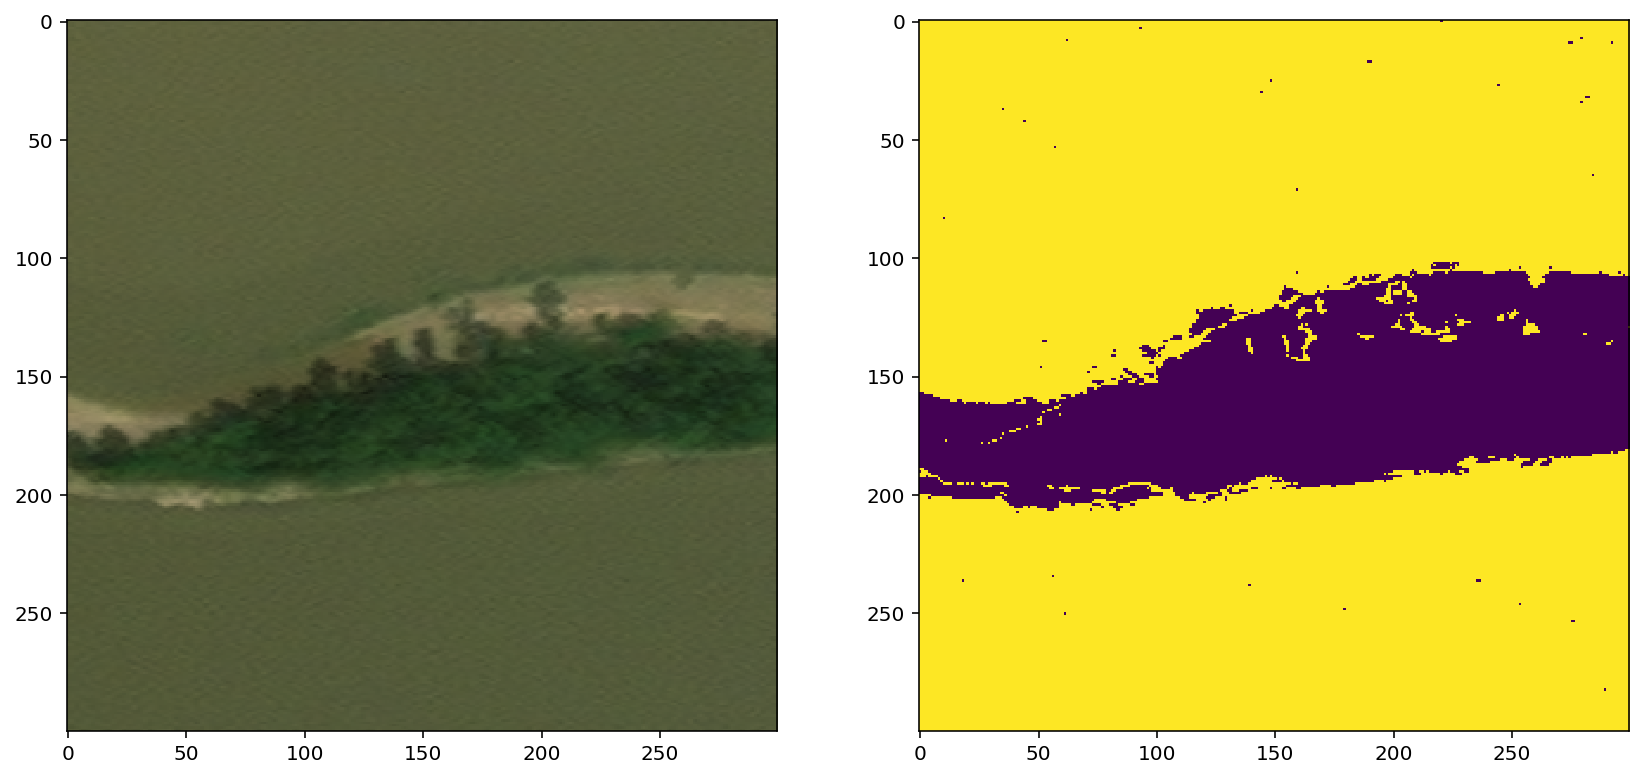

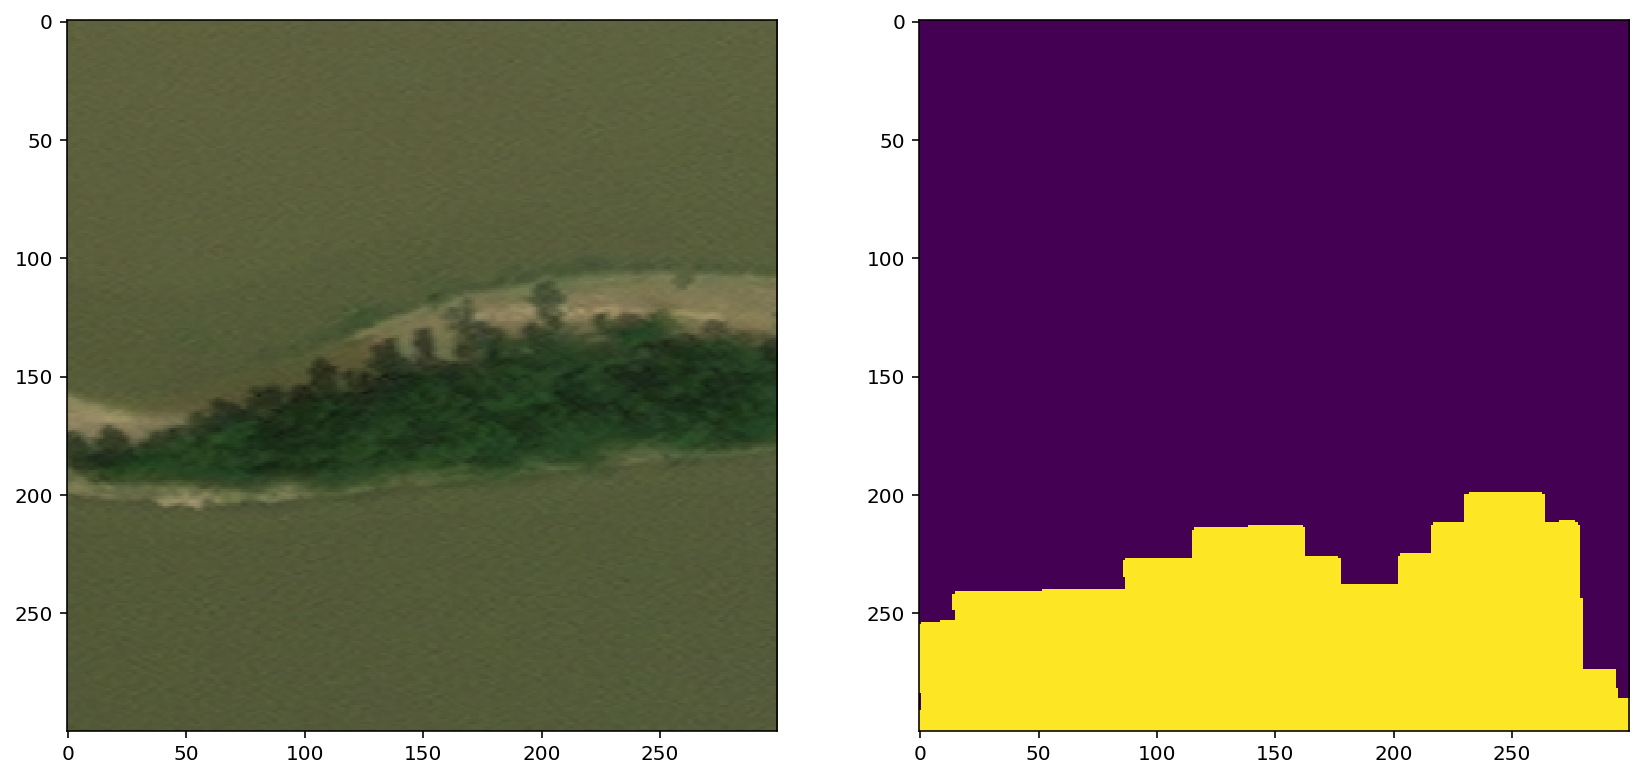

In [588]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
ax1.imshow(img*(np.expand_dims(mask==c_id,axis=2)) )
ax2.imshow(img*(np.expand_dims(mask!=c_id,axis=2)));
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
ax1.imshow(img)
ax2.imshow(255.*(mask==c_id))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
ax1.imshow(img)
ax2.imshow(DGmask);

In [499]:
color_sum = (img*(np.expand_dims(mask==0,axis=2))).sum(axis=(0,1))
color_sum

array([4987485, 7808644, 3799573], dtype=uint64)

In [500]:
color_sum.std()*1.0/color_sum.mean()

0.30393881760573993

In [445]:
1.0*color_sum[1]/color_sum[0]

1.0143891849103233

In [446]:
color_sum = (img*(np.expand_dims(mask==5,axis=2))).sum(axis=(0,1))
color_sum

array([148749, 254662, 167416], dtype=uint64)

In [447]:
color_sum.std()*1.0/color_sum.mean()

0.24260282167245836

In [448]:
1.0*color_sum[1]/color_sum[0]

1.712024954789612

1.084030206567087

In [189]:
(1.15+1.28)/2

1.2149999999999999